Notebook Goals
- **Data Loading:** Safely load the dataset from various possible locations.
- **Data Cleaning:** Clean and preprocess the raw data by dropping irrelevant columns and handling missing values.
- **Exploratory Data Analysis (EDA):** Visualize key data distributions and relationships between features.
- **Feature Engineering:** Perform feature selection and dimensionality reduction to prepare the data for modeling.
- **Class Imbalance Analysis:** Analyze the distribution of target classes to understand potential challenges for classification models.
- **Outlier Detection:** Identify and summarize outliers using the IQR method.
- **Data Snapshot:** Create a one-page summary of the dataset's initial state.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path
import pandas as pd

%matplotlib inline

#   Uploads CSV from various possible paths:

1. Absolute path, if full path is provided
2. Relative path to data/ (./data/, ../data/, etc.)
3. If you are working in Colab, /content/drive/... is also checked

In [7]:
def load_data(filename: str) -> pd.DataFrame:
    path = Path(filename)
    if path.is_absolute() and path.exists():
        print(f"Loading absolute path: {path}")
        return pd.read_csv(path, comment="#")

    candidates = [
        Path(filename),  
        Path("data") / filename,
        Path.cwd() / filename,
        Path.cwd() / "data" / filename,
        Path.home() / "data" / filename, 
        Path("/content/drive/MyDrive/NASA_Challenge/data") / filename  
    ]

    for candidate in candidates:
        if candidate.exists():
            print(f"Loading: {candidate}")
            return pd.read_csv(candidate, comment="#")

    raise FileNotFoundError(
        f"File '{filename}' not found in any of:\n" + "\n".join(str(p) for p in candidates)
    )

# Function for saving files

In [8]:
REPORTS_DIR = Path("reports") / "figures"
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

def save_and_show(fig, filename: str):
    filepath = REPORTS_DIR / filename
    fig.savefig(filepath, bbox_inches="tight", dpi=300)
    print(f"✅ Saved: {filepath}")
    plt.show(fig)   
    plt.close(fig)  

In [9]:
df = load_data("raw/TOI_raw_2025.10.01.csv")
print("Data was saved.\n")
print(df.head())

df.head()

FileNotFoundError: File 'raw/TOI_raw_2025.10.01.csv' not found in any of:
raw\TOI_raw_2025.10.01.csv
data\raw\TOI_raw_2025.10.01.csv
D:\Vlada\DS\notebooks\NASA\git\raw\TOI_raw_2025.10.01.csv
D:\Vlada\DS\notebooks\NASA\git\data\raw\TOI_raw_2025.10.01.csv
C:\Users\Влада\data\raw\TOI_raw_2025.10.01.csv
\content\drive\MyDrive\NASA_Challenge\data\raw\TOI_raw_2025.10.01.csv

# We have several classes in tfopwg_disp. This is important for further mapping into 3 broad categories.

In [5]:
unique_tfopwg_disp = df['tfopwg_disp'].unique()
print(unique_tfopwg_disp)
#planetary candidates (PC), false positives (FP), ambiguous planetary candidates (APC), and known planets (KP, previously identified) identified by the TESS mission so far. See column “TFOWPG Disposition” for classification.

['FP' 'PC' 'KP' 'APC' 'FA' 'CP']


In [6]:
df.columns.values
len(df.columns)

66

# Irrelevant or duplicate columns have been removed. This reduces noise and simplifies analysis.

In [7]:
df = df.drop(columns=['toi', 'tid','rastr','ra','decstr','st_pmra','st_pmdec','pl_tranmid','pl_insol','pl_eqt','st_dist','toi_created','rowupdate','st_pmralim','pl_tranmidlim','pl_trandeplim','pl_trandurh','pl_trandurhlim','st_tefflim','st_distlim','st_tmaglim','st_radlim','st_pmdeclim','pl_orbperlim','pl_radelim','pl_insolerr1','pl_insolerr2','pl_insollim','pl_eqterr1','pl_eqterr2','pl_eqtlim','st_logglim'],errors='ignore')
df.columns.values


array(['loc_rowid', 'tfopwg_disp', 'dec', 'st_pmraerr1', 'st_pmraerr2',
       'st_pmdecerr1', 'st_pmdecerr2', 'pl_tranmiderr1', 'pl_tranmiderr2',
       'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_trandurherr1',
       'pl_trandurherr2', 'pl_trandep', 'pl_trandeperr1',
       'pl_trandeperr2', 'pl_rade', 'pl_radeerr1', 'pl_radeerr2',
       'st_tmag', 'st_tmagerr1', 'st_tmagerr2', 'st_disterr1',
       'st_disterr2', 'st_teff', 'st_tefferr1', 'st_tefferr2', 'st_logg',
       'st_loggerr1', 'st_loggerr2', 'st_rad', 'st_raderr1', 'st_raderr2'],
      dtype=object)

In [8]:
mapping = {
    "CP": "Planet",
    "KP": "Planet",
    "PC": "Candidate",
    "APC": "Candidate",
    "FP": "False",
    "FA": "False"
}

df["disp_3class"] = df["tfopwg_disp"].map(mapping)
print(df["disp_3class"].value_counts())


disp_3class
Candidate    5139
False        1294
Planet       1266
Name: count, dtype: int64


# Data snapshot
There is a class imbalance: this is critical for further model training.

In [9]:
print("Shape of dataset:", df.shape)

class_counts = df["disp_3class"].value_counts()
class_counts_percent = df["disp_3class"].value_counts(normalize=True) * 100
print("\nClass distribution:")  # ***************
print(pd.DataFrame({"Count": class_counts, "Percent": class_counts_percent.round(2)}))

key_columns = ["pl_rade", "pl_orbper", "pl_trandep"]
missing_perc = (df[key_columns].isnull().mean() * 100).round(2)
print("\nMissing values (%):")
print(missing_perc.to_frame(name="% Missing"))


Shape of dataset: (7699, 35)

Class distribution:
             Count  Percent
disp_3class                
Candidate     5139    66.75
False         1294    16.81
Planet        1266    16.44

Missing values (%):
            % Missing
pl_rade          6.57
pl_orbper        1.39
pl_trandep       0.00


# Distribution before/after log-transform
Orbital Period has strong asymmetry; after log transformation, the distribution becomes closer to normal, which helps for ML models.

✅ Saved: reports/figures/eda_hist_pl_orbper.png


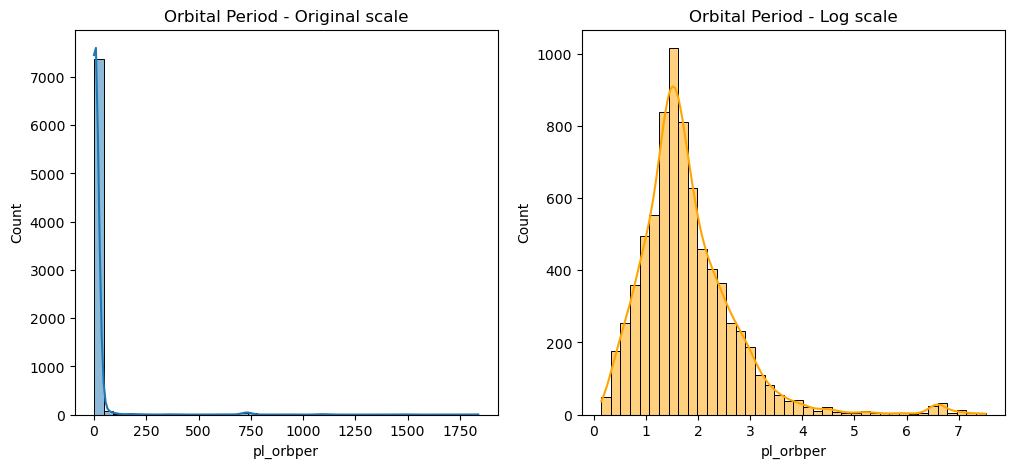

✅ Saved: reports/figures/eda_hist_pl_trandep.png


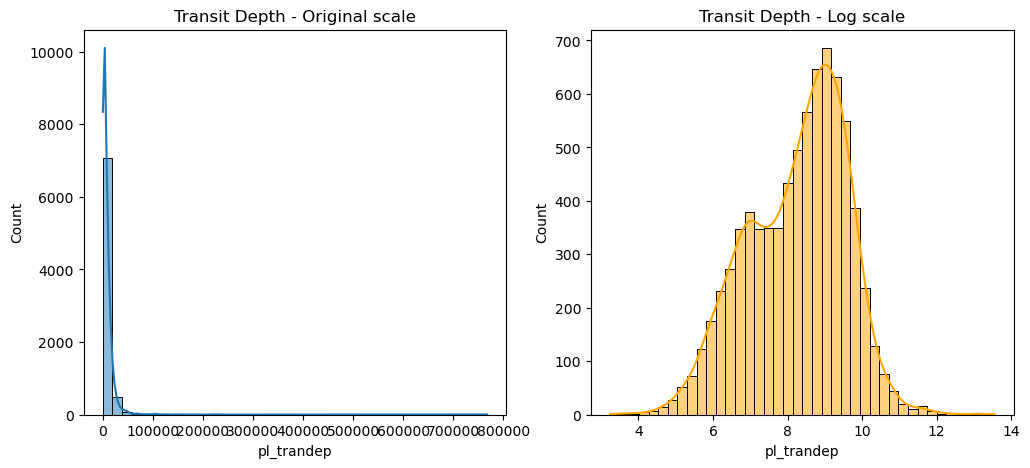

✅ Saved: reports/figures/eda_hist_pl_rade.png


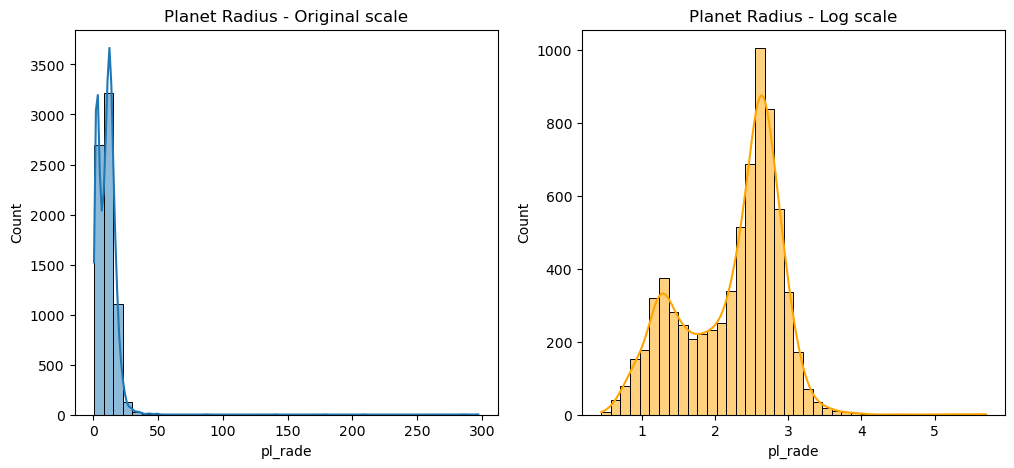

✅ Saved: reports/figures/eda_hist_st_rad.png


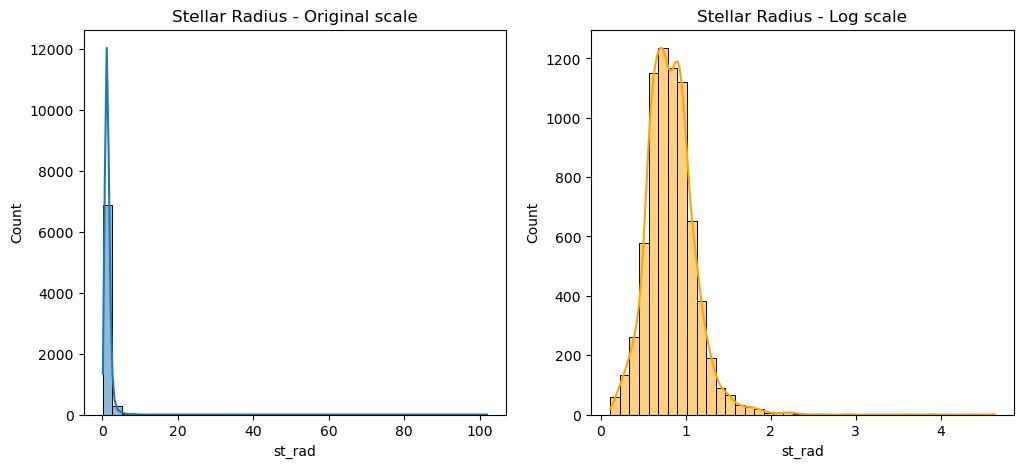

In [10]:
features_to_plot = {
    "pl_orbper": "Orbital Period",
    "pl_trandep": "Transit Depth",
    "pl_rade": "Planet Radius",
    "st_rad": "Stellar Radius"
}

for col, label in features_to_plot.items():
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.histplot(df[col].dropna(), kde=True, bins=40, ax=axes[0])
    axes[0].set_title(f"{label} - Original scale")

    sns.histplot(np.log1p(df[col].dropna()), kde=True, bins=40, color="orange", ax=axes[1])
    axes[1].set_title(f"{label} - Log scale")

    save_and_show(fig, f"eda_hist_{col}.png")



# Heatmap Missing Values
The omissions are concentrated in selected features. This will help decide which columns to impute or discard.

✅ Saved: reports/figures/eda_heatmap_missing.png


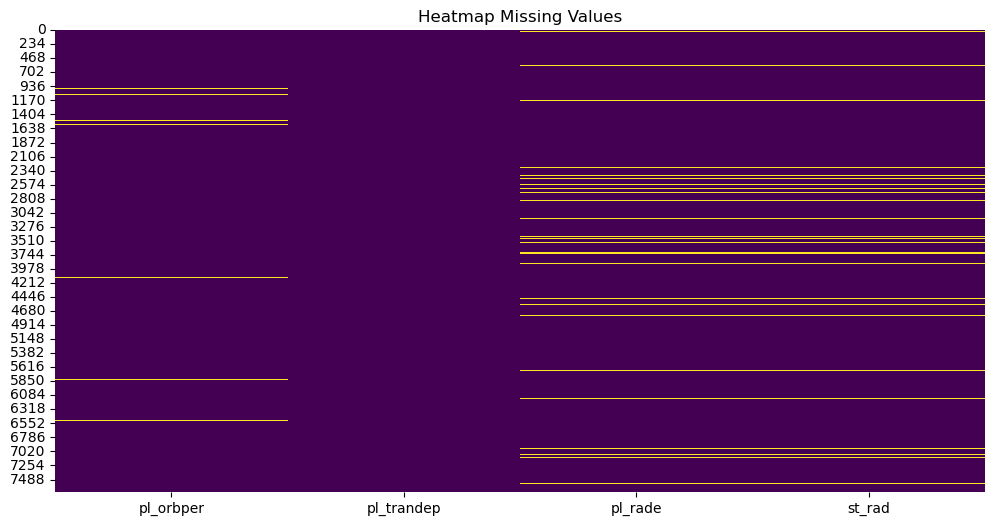

In [11]:
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(df[features_to_plot.keys()].isnull(), cbar=False, cmap="viridis", ax=ax)
ax.set_title("Heatmap Missing Values")
save_and_show(fig, "eda_heatmap_missing.png")

# Сorrelation analysis with heatmap


✅ Saved: reports/figures/eda_heatmap_corr.png


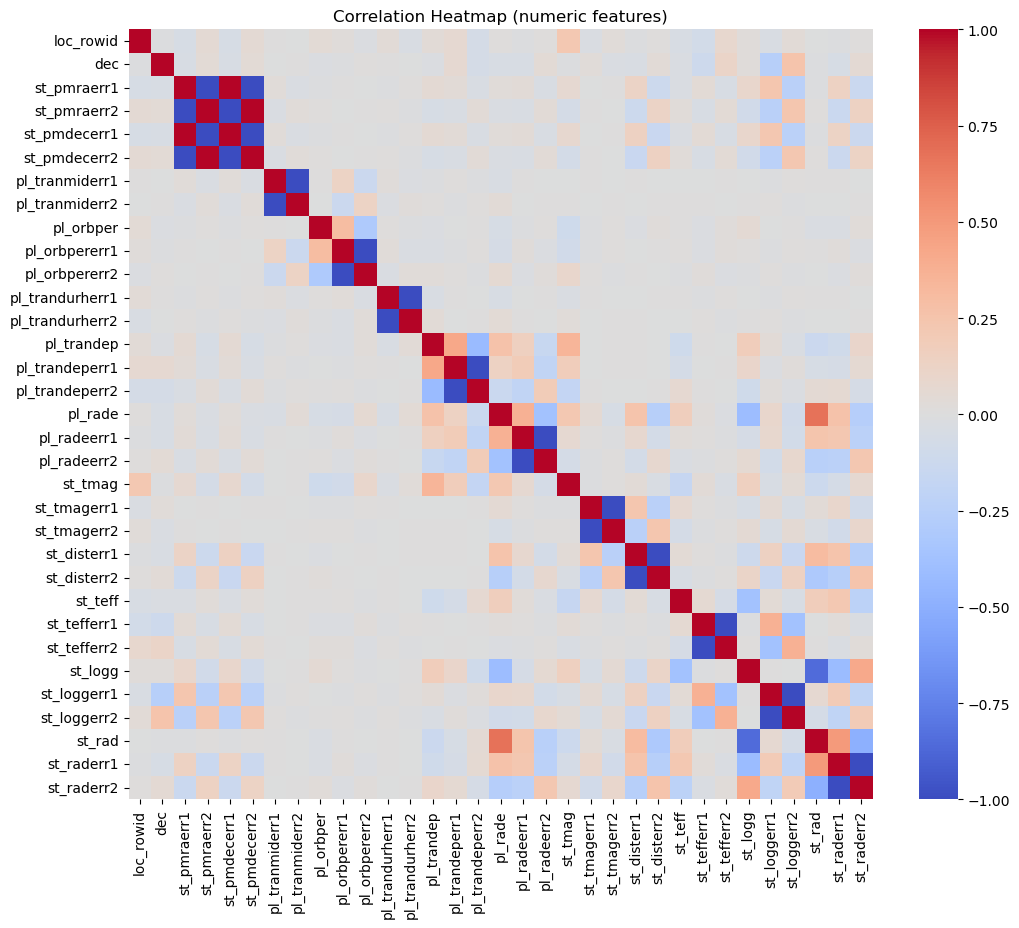

In [12]:
numeric_df = df.select_dtypes(include=['float64','int64'])
corr = numeric_df.corr()

fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(corr, cmap="coolwarm", annot=False, ax=ax)
ax.set_title("Correlation Heatmap (numeric features)")
save_and_show(fig, "eda_heatmap_corr.png")

# Distribution of Planet Radius across Disposition Classes
Planets with different disposition classes have different radius distributions. This is important because planet size can be a strong predictor of classification.

✅ Saved: reports/figures/eda_boxplot_radius.png


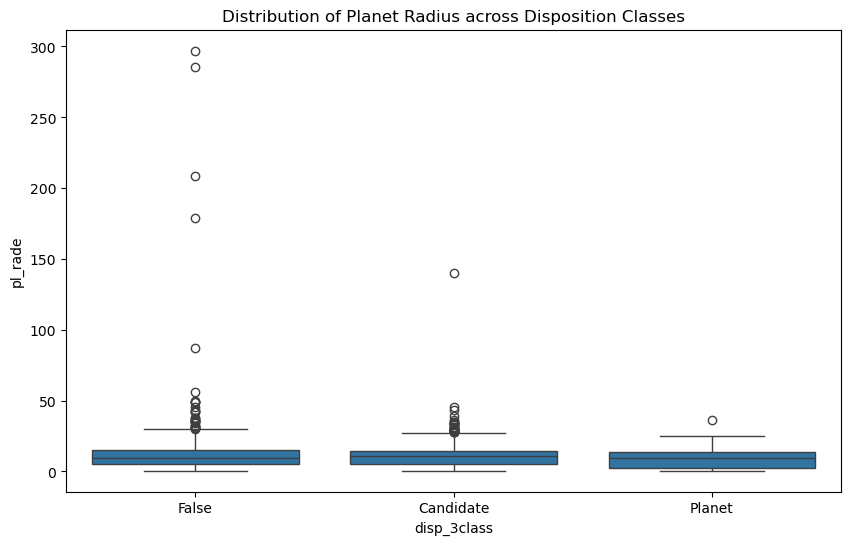

In [13]:
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(x="disp_3class", y="pl_rade", data=df, ax=ax)
ax.set_title("Distribution of Planet Radius across Disposition Classes")
save_and_show(fig, "eda_boxplot_radius.png")

# Planet Radius vs Disposition


✅ Saved: reports/figures/eda_violin_radius.png


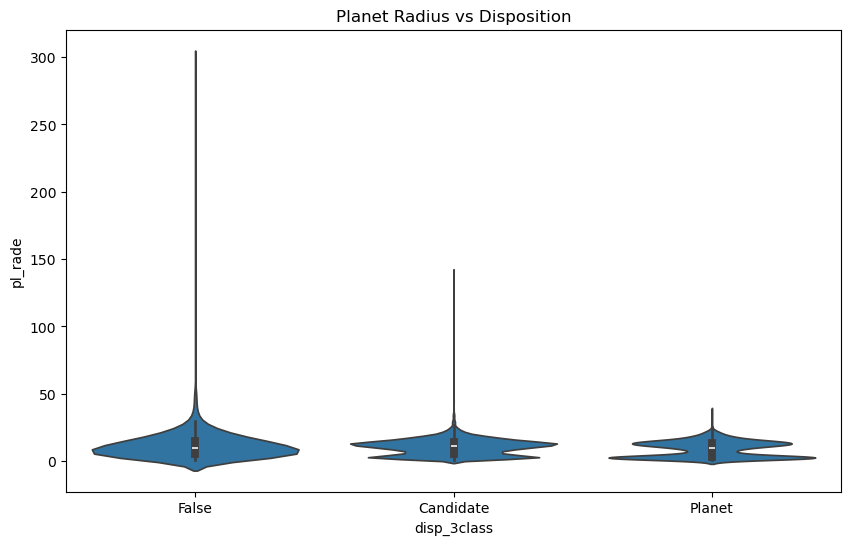

In [14]:
fig, ax = plt.subplots(figsize=(10,6))
sns.violinplot(x="disp_3class", y="pl_rade", data=df, density_norm="width", ax=ax)
ax.set_title("Planet Radius vs Disposition")
save_and_show(fig, "eda_violin_radius.png")


# Planet Transit Depth Value vs Disposition
The depth of transit varies significantly between classes, especially for confirmed planets. This confirms its informative value as a feature.

✅ Saved: reports/figures/eda_violin_transit_depth.png


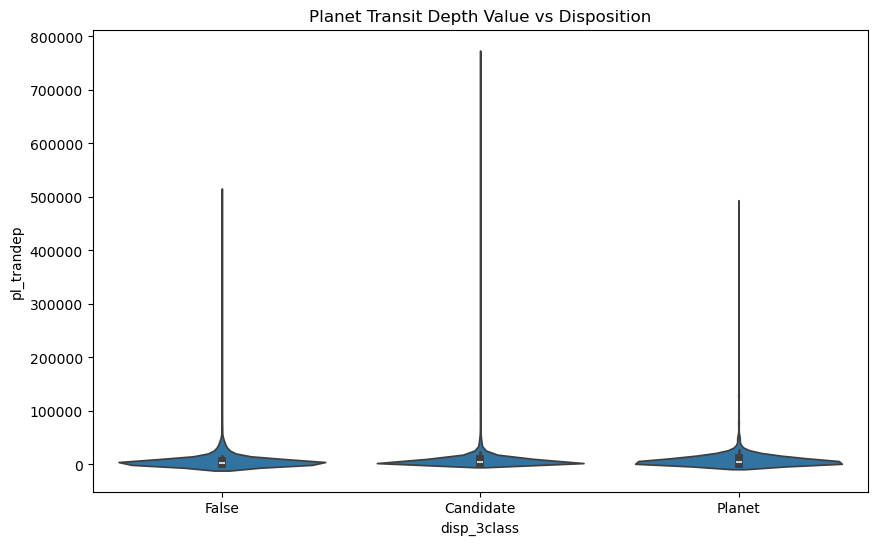

In [15]:
fig, ax = plt.subplots(figsize=(10,6))
sns.violinplot(x="disp_3class", y="pl_trandep", data=df, density_norm="width", ax=ax)
ax.set_title("Planet Transit Depth Value vs Disposition")
save_and_show(fig, "eda_violin_transit_depth.png")

# Orbital Period Distributions
Confirmed planets show clustering of periods within certain ranges. This is important for finding patterns in planetary dynamics.

✅ Saved: reports/figures/eda_hist_orbital_period_by_class.png


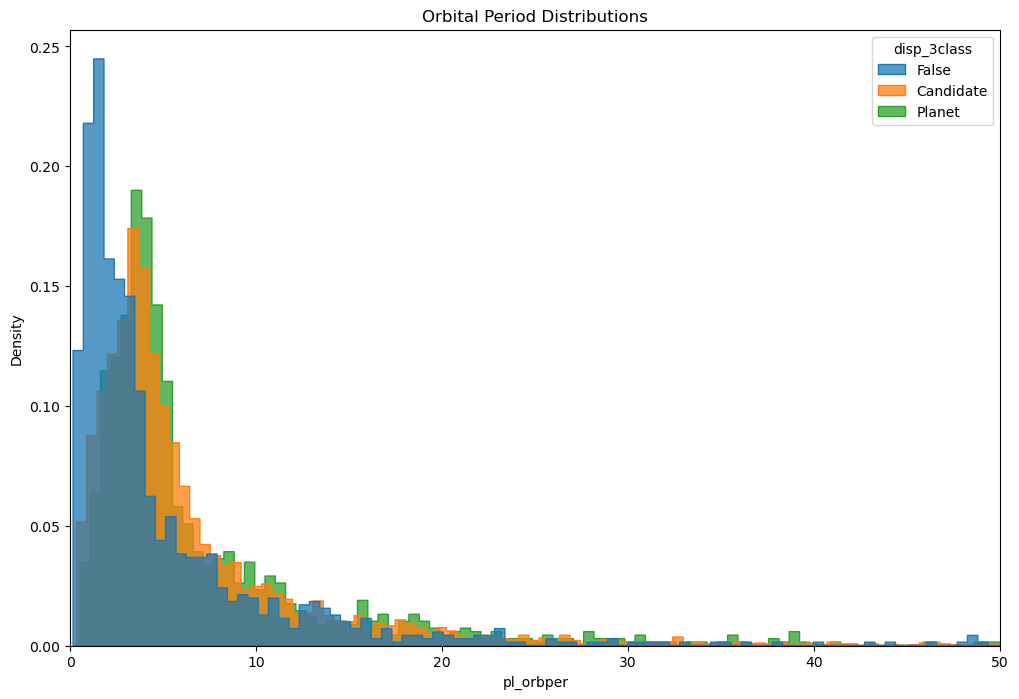

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,8))
sns.histplot(
    data=df,
    x="pl_orbper",
    hue="disp_3class",
    element="step",
    stat="density",
    common_norm=False,
    multiple="dodge",
    ax=ax
)
ax.set_xlim(0, 50)
ax.set_title("Orbital Period Distributions")
save_and_show(fig, "eda_hist_orbital_period_by_class.png")


# Quantitative feature-market relationships

**Mutual Information (MI): feature relevance to the target**

*Missing values*
Some of the numerical features have a large number of missing values. This will determine the strategy for imputation or feature filtering.

In [17]:
X=numeric_df
X.isnull().sum().sort_values(ascending=False).head(15)


st_loggerr1    2270
st_loggerr2    2270
st_raderr1     1962
st_raderr2     1962
pl_radeerr2    1623
pl_radeerr1    1623
st_logg         856
st_disterr1     707
st_disterr2     707
st_rad          507
pl_rade         506
st_tefferr2     474
st_tefferr1     474
st_teff         161
st_pmraerr2     134
dtype: int64

Columns with a large number of missing values are discarded, and the rest are imputed with the median. This makes the data ready for ML models.

In [18]:
X = X.dropna(axis=1, thresh=len(X)*0.7)  
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)


MI shows which features are most informative for classification (e.g., radius, transit depth). This is important for feature selection.

In [19]:
from sklearn.feature_selection import mutual_info_classif

y = df["disp_3class"]
mi_scores = mutual_info_classif(X_imputed, y, discrete_features='auto', random_state=42)

mi_df = pd.DataFrame({
    "Feature": X.columns,
    "MI_Score": mi_scores
}).sort_values(by="MI_Score", ascending=False)

print(mi_df)


            Feature  MI_Score
0         loc_rowid  0.185316
30           st_rad  0.078783
19          st_tmag  0.068365
22      st_disterr1  0.067305
23      st_disterr2  0.064975
32       st_raderr2  0.062426
27          st_logg  0.062184
31       st_raderr1  0.060332
25      st_tefferr1  0.059069
11  pl_trandurherr1  0.056535
12  pl_trandurherr2  0.055613
17      pl_radeerr1  0.049900
28      st_loggerr1  0.049870
18      pl_radeerr2  0.048515
26      st_tefferr2  0.047661
29      st_loggerr2  0.046056
9     pl_orbpererr1  0.044358
4      st_pmdecerr1  0.043302
16          pl_rade  0.042085
7    pl_tranmiderr2  0.041828
24          st_teff  0.041657
6    pl_tranmiderr1  0.040107
5      st_pmdecerr2  0.038025
10    pl_orbpererr2  0.036095
2       st_pmraerr1  0.035502
3       st_pmraerr2  0.030939
15   pl_trandeperr2  0.030425
14   pl_trandeperr1  0.030247
13       pl_trandep  0.028085
21      st_tmagerr2  0.026988
1               dec  0.024284
8         pl_orbper  0.014218
20      st

3        st_pmralim  0.000000
9     pl_tranmidlim  0.000000
21    pl_trandeplim  0.000000
14      pl_trandurh  0.000000
17   pl_trandurhlim  0.000000
36       st_tefflim  0.000000
32       st_distlim  0.000000
29       st_tmaglim  0.000000
44        st_radlim  0.000000

# PrincipalComponentAnalysis

PCA reduces high-dimensional numeric features into 2D or 3D “summary axes” that explain the most variance.
If clusters separate → numeric features contain strong signals for classification, overlap → the task is harder (makes ML more challenging).
explained_variance_ratio_ shows how much of the total variance PC1 + PC2 capture (often 30–60%).

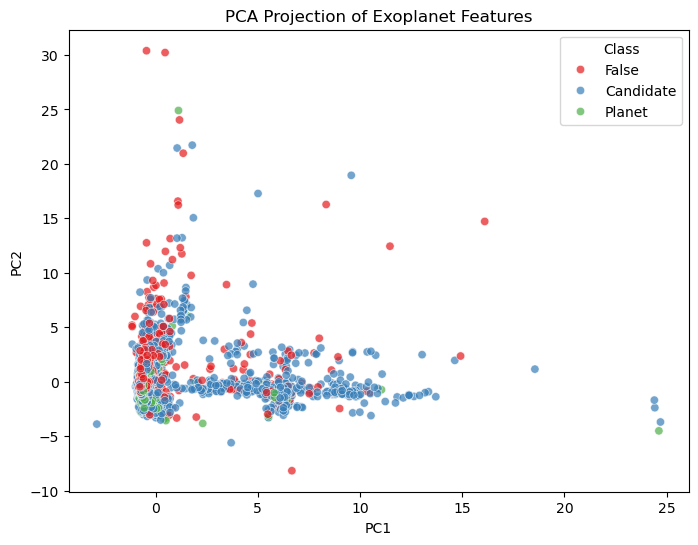

Explained variance ratio: [0.12269106 0.09382291]


<Figure size 640x480 with 0 Axes>

In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X_imputed)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["Class"] = y.values

plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Class", alpha=0.7, palette="Set1")
plt.title("PCA Projection of Exoplanet Features")
plt.show()

os.makedirs("./reports/figures", exist_ok=True)
plt.savefig("./reports/figures/eda_pca_projection.png", dpi=300, bbox_inches="tight")

print("Explained variance ratio:", pca.explained_variance_ratio_)



# Outliers IQR
The largest deviations are observed in the radius and period parameters. This can distort distributions and models.

In [28]:
def detect_outliers_iqr(df, features):
    outlier_summary = {}
    for col in features:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower) | (df[col] > upper)][col]
        outlier_summary[col] = len(outliers)
    return pd.DataFrame.from_dict(outlier_summary, orient="index", columns=["#Outliers"])

numeric_features = df.select_dtypes(include=['float64','int64']).columns
outlier_counts = detect_outliers_iqr(df, numeric_features)
print(outlier_counts.sort_values("#Outliers", ascending=False).head(10))


               #Outliers
st_loggerr1         1370
st_loggerr2         1370
st_tmagerr2         1256
st_tmagerr1         1256
pl_orbpererr2       1223
pl_orbpererr1       1223
st_tefferr2         1030
st_tefferr1         1030
st_pmdecerr1         911
st_pmdecerr2         911


# Class Balance

NameError: name 'df' is not defined

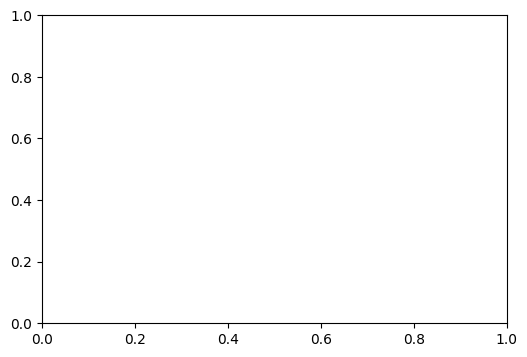

In [10]:
# === Class distribution barplot ===
fig, ax = plt.subplots(figsize=(6,4))
class_counts_norm = df['disp_3class'].value_counts(normalize=True) * 100
sns.barplot(x=class_counts_norm.index, y=class_counts_norm.values, palette="Set2", ax=ax)
ax.set_ylabel("Percentage (%)")
ax.set_title("Class Balance")


save_and_show(fig, "class_distribution_percentage.png")

There is a significant imbalance between classes (confirmed planets vs. candidates/false positives). This is critical for choosing metrics and balancing the dataset.

✅ Saved: reports/figures/class_balance_count.png


/tmp/ipykernel_11993/999258123.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="Set2", ax=ax)


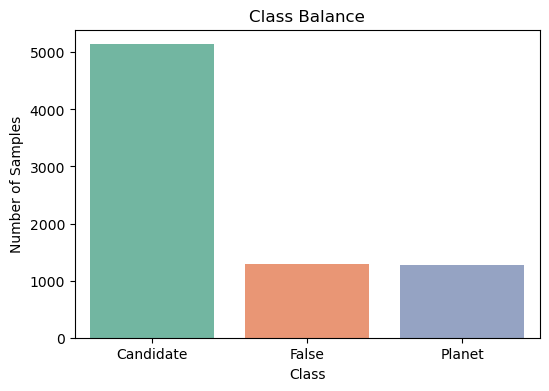

In [35]:
class_counts = df['disp_3class'].value_counts()

fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="Set2", ax=ax)
ax.set_title("Class Balance")
ax.set_ylabel("Number of Samples")
ax.set_xlabel("Class")

# Збереження та показ
save_and_show(fig, "class_balance_count.png")


# Stratified Feature Analysis
Descriptive statistics by group show different medians and variations in key parameters. This highlights the difference between classes.

NameError: name 'df' is not defined

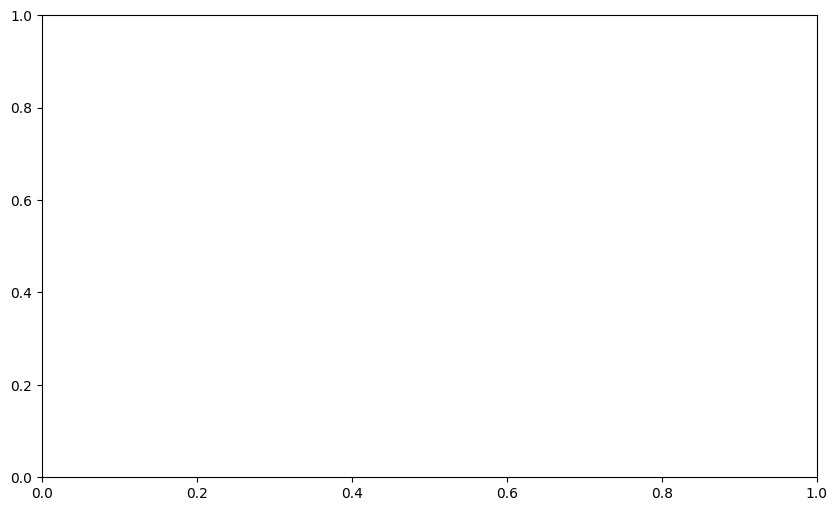

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(data=df, x="disp_3class", y="pl_rade", palette="Set2", ax=ax)
ax.set_title("Planetary Radius by Class")

save_and_show(fig, "boxplot_planet_radius.png")

group_stats = df.groupby("disp_3class")[["pl_rade","pl_orbper","pl_trandep"]].describe()
print(group_stats)


# Descriptive Statistics
Overall statistics show a wide range of values. This confirms the need for normalization/scaling.

In [25]:
desc_stats = df.describe().T  
print(desc_stats[["min","25%","50%","mean","75%","max","std"]])


                          min          25%          50%         mean  \
loc_rowid        1.000000e+00  1925.500000  3850.000000  3850.000000   
dec             -8.947151e+01   -43.340501     4.779380     1.192194   
st_pmraerr1      1.500000e-02     0.038000     0.051000     0.228825   
st_pmraerr2     -8.000000e+00    -0.080000    -0.051000    -0.228825   
st_pmdecerr1     1.600000e-02     0.038000     0.049000     0.222832   
st_pmdecerr2    -8.000000e+00    -0.071000    -0.049000    -0.222832   
pl_tranmiderr1   8.000000e-06     0.001069     0.002027     0.003666   
pl_tranmiderr2  -3.305344e+00    -0.003490    -0.002027    -0.003666   
pl_orbper        1.520760e-01     2.491871     4.090083    17.746531   
pl_orbpererr1    1.000000e-07     0.000008     0.000024     0.000310   
pl_orbpererr2   -2.152330e-02    -0.000129    -0.000024    -0.000310   
pl_trandurherr1  1.000000e-03     0.139000     0.263000     0.362561   
pl_trandurherr2 -1.676152e+02    -0.441000    -0.263000    -0.36

The medians for each class are clearly distinct, indicating the informativeness of the features for classification.

In [26]:
grouped_medians = df.groupby("disp_3class").median(numeric_only=True)
print(grouped_medians.head())


             loc_rowid        dec  st_pmraerr1  st_pmraerr2  st_pmdecerr1  \
disp_3class                                                                 
Candidate       4318.0   3.788601        0.050       -0.050         0.047   
False           2591.5  11.801057        0.054       -0.054         0.053   
Planet          3300.5   4.194573        0.056       -0.056         0.051   

             st_pmdecerr2  pl_tranmiderr1  pl_tranmiderr2  pl_orbper  \
disp_3class                                                            
Candidate          -0.047        0.002135       -0.002135   4.320508   
False              -0.053        0.002436       -0.002436   2.955188   
Planet             -0.051        0.001188       -0.001188   4.228234   

             pl_orbpererr1  ...  st_disterr2  st_teff  st_tefferr1  \
disp_3class                 ...                                      
Candidate         0.000024  ...     -5.66475  5811.05      128.700   
False             0.000044  ...     -4.5195

# Summary (TL;DR)

Data cleaned: columns with many missing values removed, the rest imputed with the median.
The classes are significantly unbalanced (many candidates and false positives), which affects the choice of metrics and algorithms.
Log transformation reduces the asymmetry of distributions and makes them more suitable for ML.
There are groups of highly correlated features → feature selection or PCA is needed to reduce multicollinearity.
PCA shows that the data is partially divided into two main components.
The largest outliers are in orbital period and planet radius → important to consider for models.
The distributions of key parameters (radius, depth) differ between classes → useful for classification.
Overall statistics highlight the need for normalization and balancing of the dataset.